In [149]:
# Kiley Huffman
# QBIO 465
# Assignment 9
# Due: Thurs. 4/24

# Part 1: Data Visualization [1 pts]

1. Download the data. Load and standardize the images using min-max normalization. Use an 80%-20% split of the data for training and testing in this assignment.

3. Use visualization to explore the images. What differences do you notice between the images?

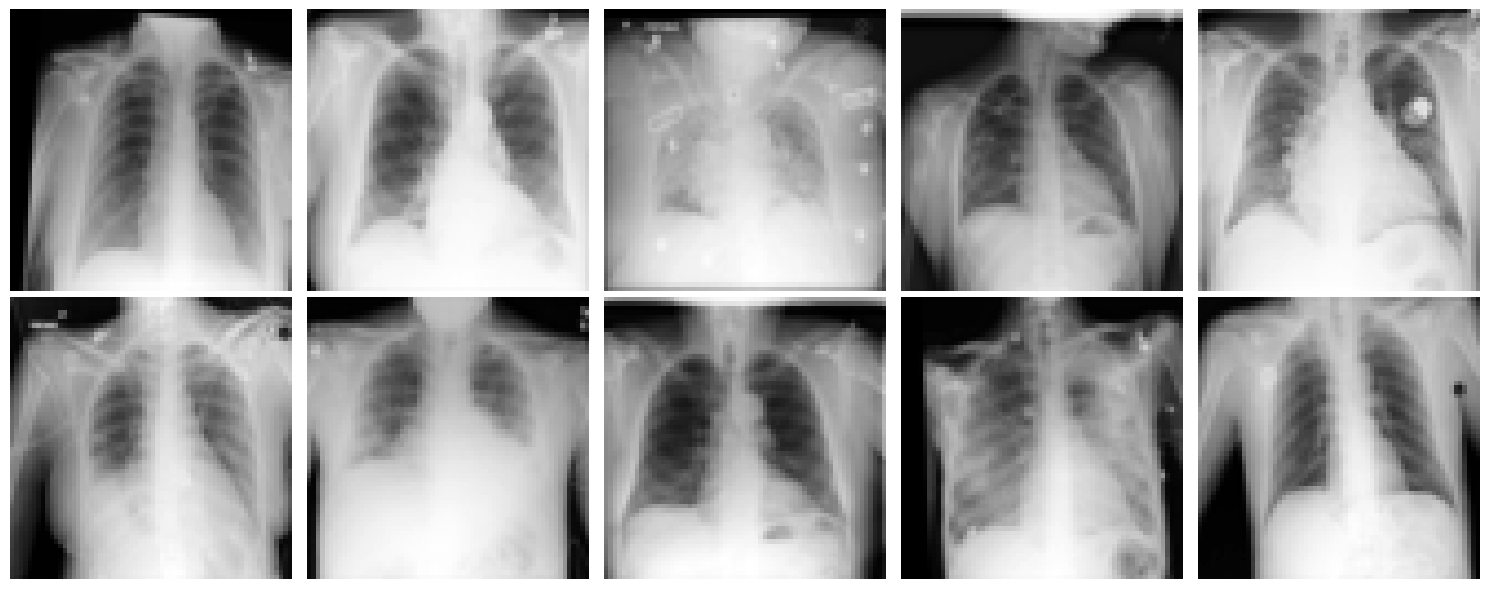

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the data
data = np.load('xray_images.npz')
images = data['images']  # get images

# Standardize the images using min-max normalization to scale pixel values
images = (images - images.min()) / (images.max() - images.min())

# Train-test split: 80% training, 20% testing
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)

# Us visualization to explore the images: 
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(len(X_train))
    ax.imshow(X_train[idx], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

What differences do you notice between the images?:

    The images show differencs in lung opacity, heart size, diaphragm/rib spacing, quality, and view angles. 
    
    Lung Opacity: Some images show clear lungs, while others have haziness or cloudy areas. 
    
    Heart Size: The size and shape of the heart vary. 
    
    Diaphragm and Ribs: There are ariations in the diaphragm position and/or rib spacing. 
    
    Quality: Some images have different contrast or brightness levels. Objects are visible in some images. 
    
    View Angles: Some X-rays are taken from different angles.

# Part 2: Generative Variational Autoencoder

• Train a convolutional variational autoencoder to learn a low-dimensional representation of the data.

• Use three different latent space sizes: 4, 16, and 32 (i.e., build separate models).

• Use two a two-term loss function:

o Reconstruction loss: Binary Cross Entropy between each pixel of the input and reconstructed images.

o Kullback-Leibler (KL) loss: KL divergence between the latent distribution and a standard normal distribution.

• Train the model for at least 100 epochs (adjust as needed for optimal results).

• Report the training and testing history plots

In [5]:
# Reshape the images
images = np.expand_dims(images, axis=-1)  # change the shape to (11219, 64, 64, 1)

# Verify the new shape
print(images.shape)


(11219, 64, 64, 1)


In [6]:
from tensorflow.keras import layers

# Create Sampling class
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

        # Compute and add KL divergence loss 
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(kl_loss)
        return z

# Train a convolutional variational autoencoder to learn a low-dimensional representation of the data.
def build_vae(latent_dim):
    # Encoder
    inputs = layers.Input(shape=(64, 64, 1))
    
    # Use Conv2D with stride=2 for each encoder layer
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
    
    shape_before_flatten = tf.keras.backend.int_shape(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_input = layers.Dense(np.prod(shape_before_flatten[1:]), activation='relu')(z)
    x = layers.Reshape(shape_before_flatten[1:])(decoder_input)
    
    # Conv2DTranspose with stride=2 for each decoder layer
    x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    vae = models.Model(inputs, outputs)

    # Just use BCE loss (KL is added via add_loss)
    vae.compile(optimizer='adam', loss='binary_crossentropy')

    return vae, z_mean, z_log_var

2025-04-20 18:47:33.691257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, backend as K

# Train on a subset of the data (code would not run when using the whole data set)
X_train_small = X_train[:100]
X_test_small = X_test[:100]

# Use three different latent space sizes: 4, 16, and 32 (i.e., build separate models).
latent_dims = [4, 16, 32]
history = {}

for latent_dim in latent_dims:
    print(f"\nTraining VAE with latent space size: {latent_dim}")
    
    vae, z_mean, z_log_var = build_vae(latent_dim)
    
    history[latent_dim] = vae.fit(
        X_train_small, X_train_small,
        
        # Train the model for at least 100 epochs (adjust as needed for optimal results).
        epochs=100,
        batch_size=32,
        validation_data=(X_test_small, X_test_small),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ]
    )


Training VAE with latent space size: 4
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 451ms/step - loss: 0.7795 - val_loss: 0.6941
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - loss: 0.6938 - val_loss: 0.6932
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - loss: 0.6931 - val_loss: 0.6925
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - loss: 0.6924 - val_loss: 0.6901
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 0.6895 - val_loss: 0.6820
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - loss: 0.6802 - val_loss: 0.6699
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - loss: 0.6701 - val_loss: 0.6653
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 0.6666 - val_loss: 0.6634
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.6643 - val_loss: 0.6626
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - loss: 0.6622 - val_loss: 0.6619
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - loss: 0.6639 - val_loss: 0.6624
Epoch 12/100
4/4 ━━━━━━

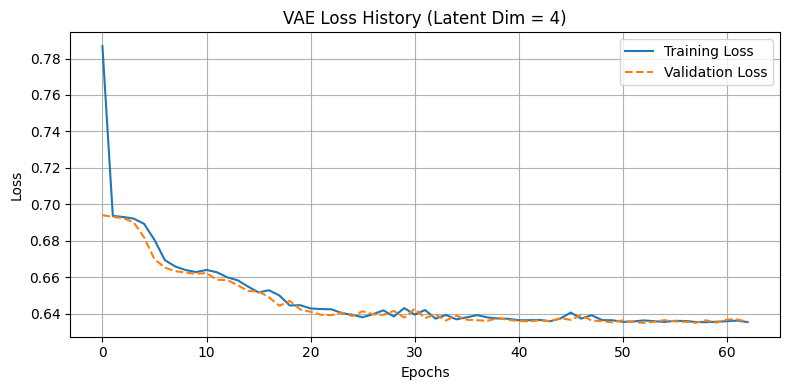

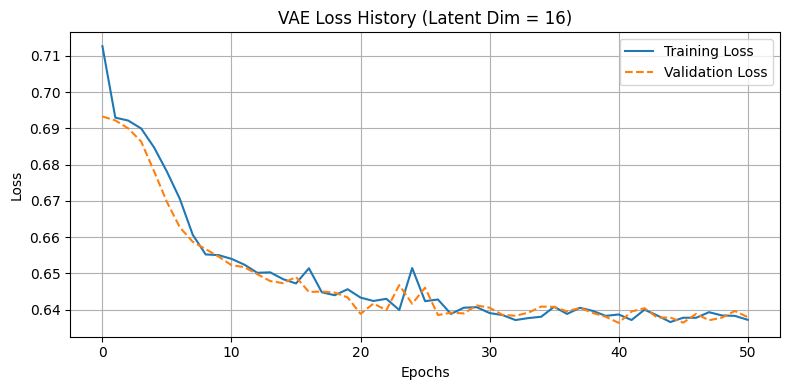

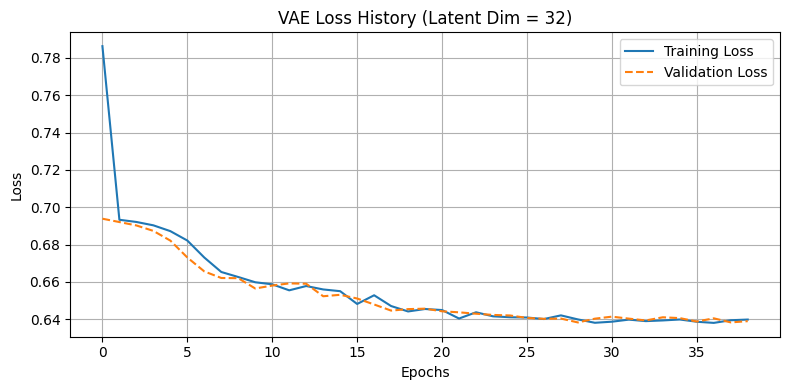

In [12]:
import matplotlib.pyplot as plt

latent_dims = [4, 16, 32]

# Report the training and testing history plots.
for latent_dim in latent_dims:
    hist = history[latent_dim]

    plt.figure(figsize=(8, 4))
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.title(f"VAE Loss History (Latent Dim = {latent_dim})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Part 3: Visualize Reconstruction and PCA/t-SNE [2 pts]
• For each model from Part 2:

o Visualize the original image vs. reconstructed image for 10 images from the test dataset


 Showing Reconstructions for Latent Dim = 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


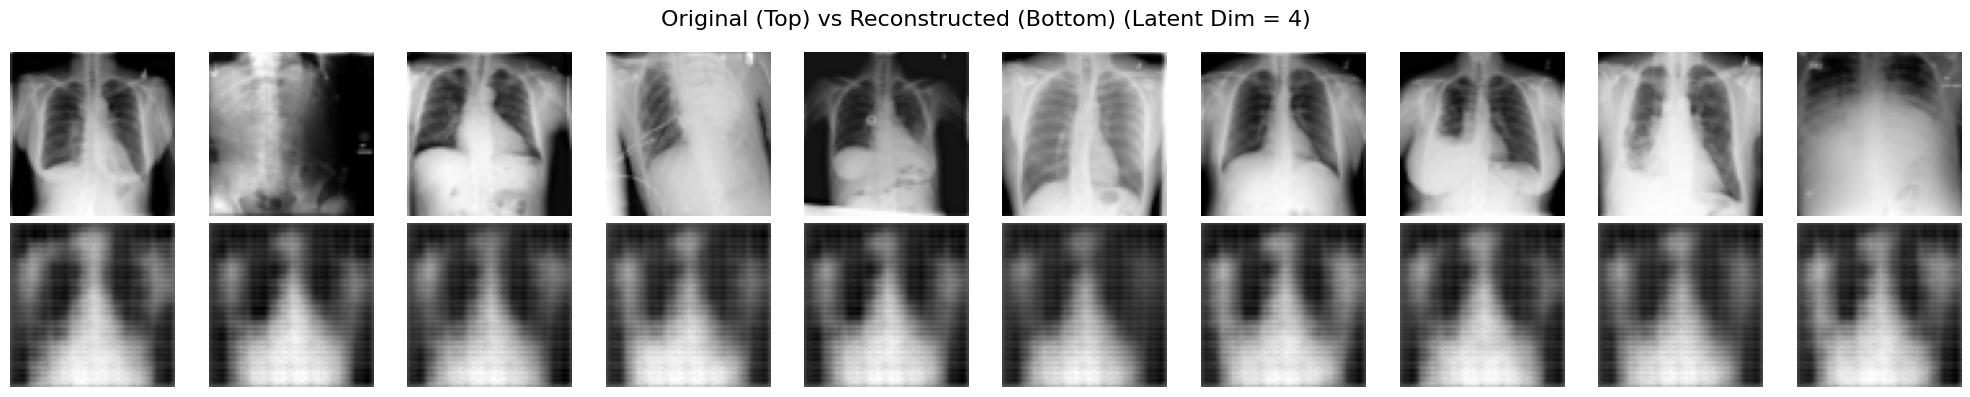


 Showing Reconstructions for Latent Dim = 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


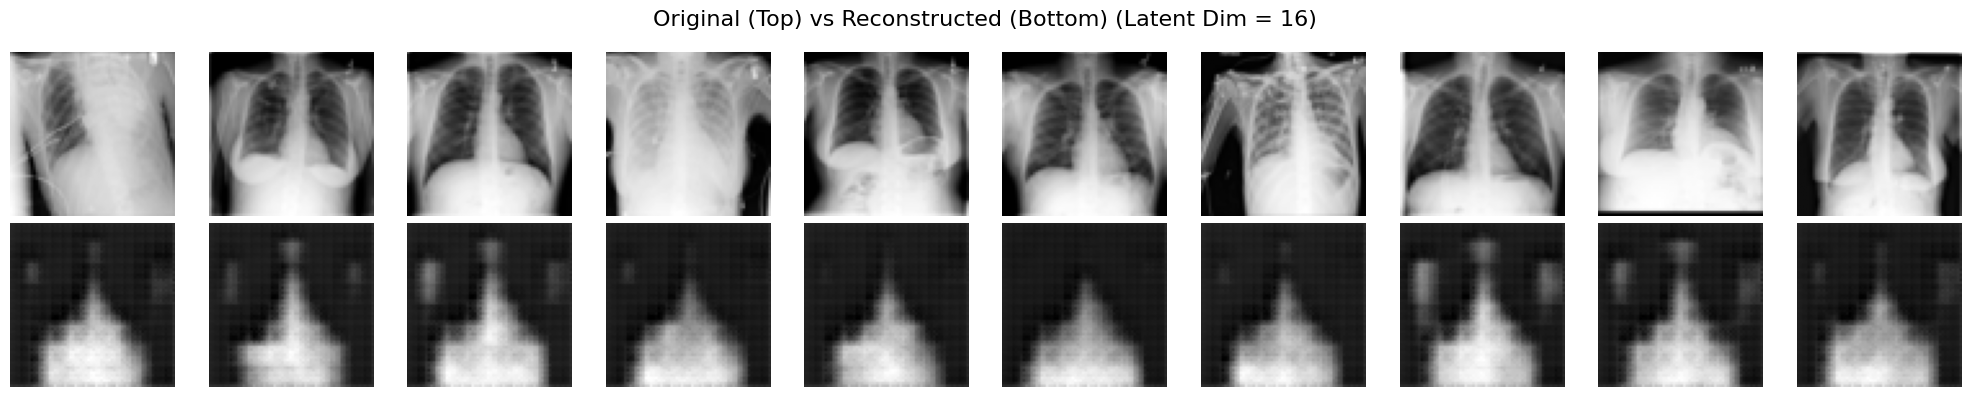


 Showing Reconstructions for Latent Dim = 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


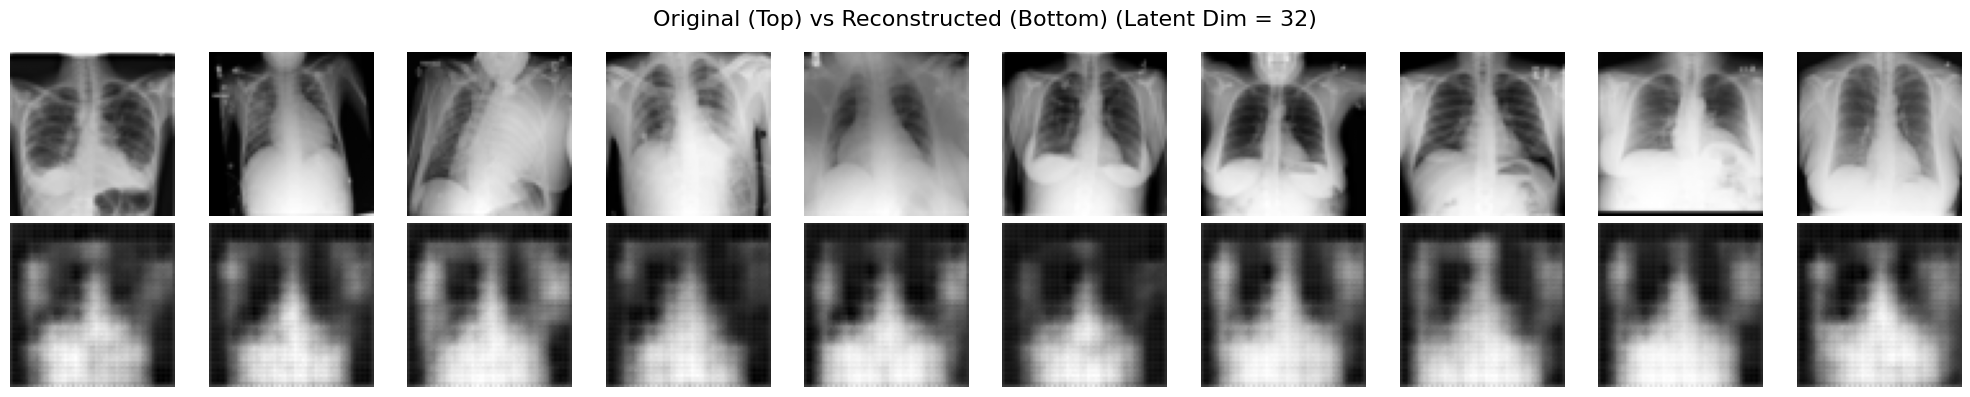

In [19]:
# Visualize the original image vs. reconstructed image for 10 images from the test dataset.
def show_reconstructions(model, X_data, latent_dim):
    n = 10
    idxs = np.random.choice(len(X_data), n, replace=False)
    originals = X_data[idxs]
    reconstructions = model.predict(originals)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i].squeeze(), cmap='gray')
        ax.axis('off')

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].squeeze(), cmap='gray')
        ax.axis('off')

    plt.suptitle(f"Original (Top) vs Reconstructed (Bottom) (Latent Dim = {latent_dim})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
latent_dims = [4, 16, 32]

for latent_dim in latent_dims:
    print(f"\n Showing Reconstructions for Latent Dim = {latent_dim}")
    vae, _, _ = build_vae(latent_dim)  # rebuild the model
    vae.fit(X_train_small, X_train_small, epochs=10, batch_size=32, validation_data=(X_test_small, X_test_small), verbose=0)  # quick training on subset

    show_reconstructions(vae, X_test_small, latent_dim)


o Randomly sample 1000 images from the training dataset and encode each one into its latent vector.

In [37]:
import numpy as np
import tensorflow as tf

# Function to encode 1000 images to latent space vectors without training
def encode_latent_vectors(encoder, X_train_sampled):
    # Encode the sampled images using the encoder model (only pass through the encoder, no training)
    z_mean, _, _ = encoder.predict(X_train_sampled, batch_size=32)
    
    return z_mean

# Sample 1000 images from the training set
num_samples = 1000
idxs = np.random.choice(len(X_train_sampled), num_samples, replace=False)
X_train_sampled_1000 = X_train_sampled[idxs]

latent_vectors_dict = {}

# For each latent space dimension (4, 16, 32), encode the images
latent_dims = [4, 16, 32]
for latent_dim in latent_dims:
    print(f"Encoding images with latent dim = {latent_dim}")
    vae, encoder, _ = build_vae(latent_dim)
    
    # Encode latent vectors without training
    latent_vectors = encode_latent_vectors(encoder, X_train_sampled_1000)
    
    # Store the latent vectors
    latent_vectors_dict[latent_dim] = latent_vectors

    print(f"Encoding complete for latent dim = {latent_dim}")


Encoding images with latent dim = 4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Encoding complete for latent dim = 4
Encoding images with latent dim = 16
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Encoding complete for latent dim = 16
Encoding images with latent dim = 32
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Encoding complete for latent dim = 32


o Cluster the vectors (K-means clustering) and visualize images from a few of the clusters.

Clustering latent vectors (latent dim = 4)


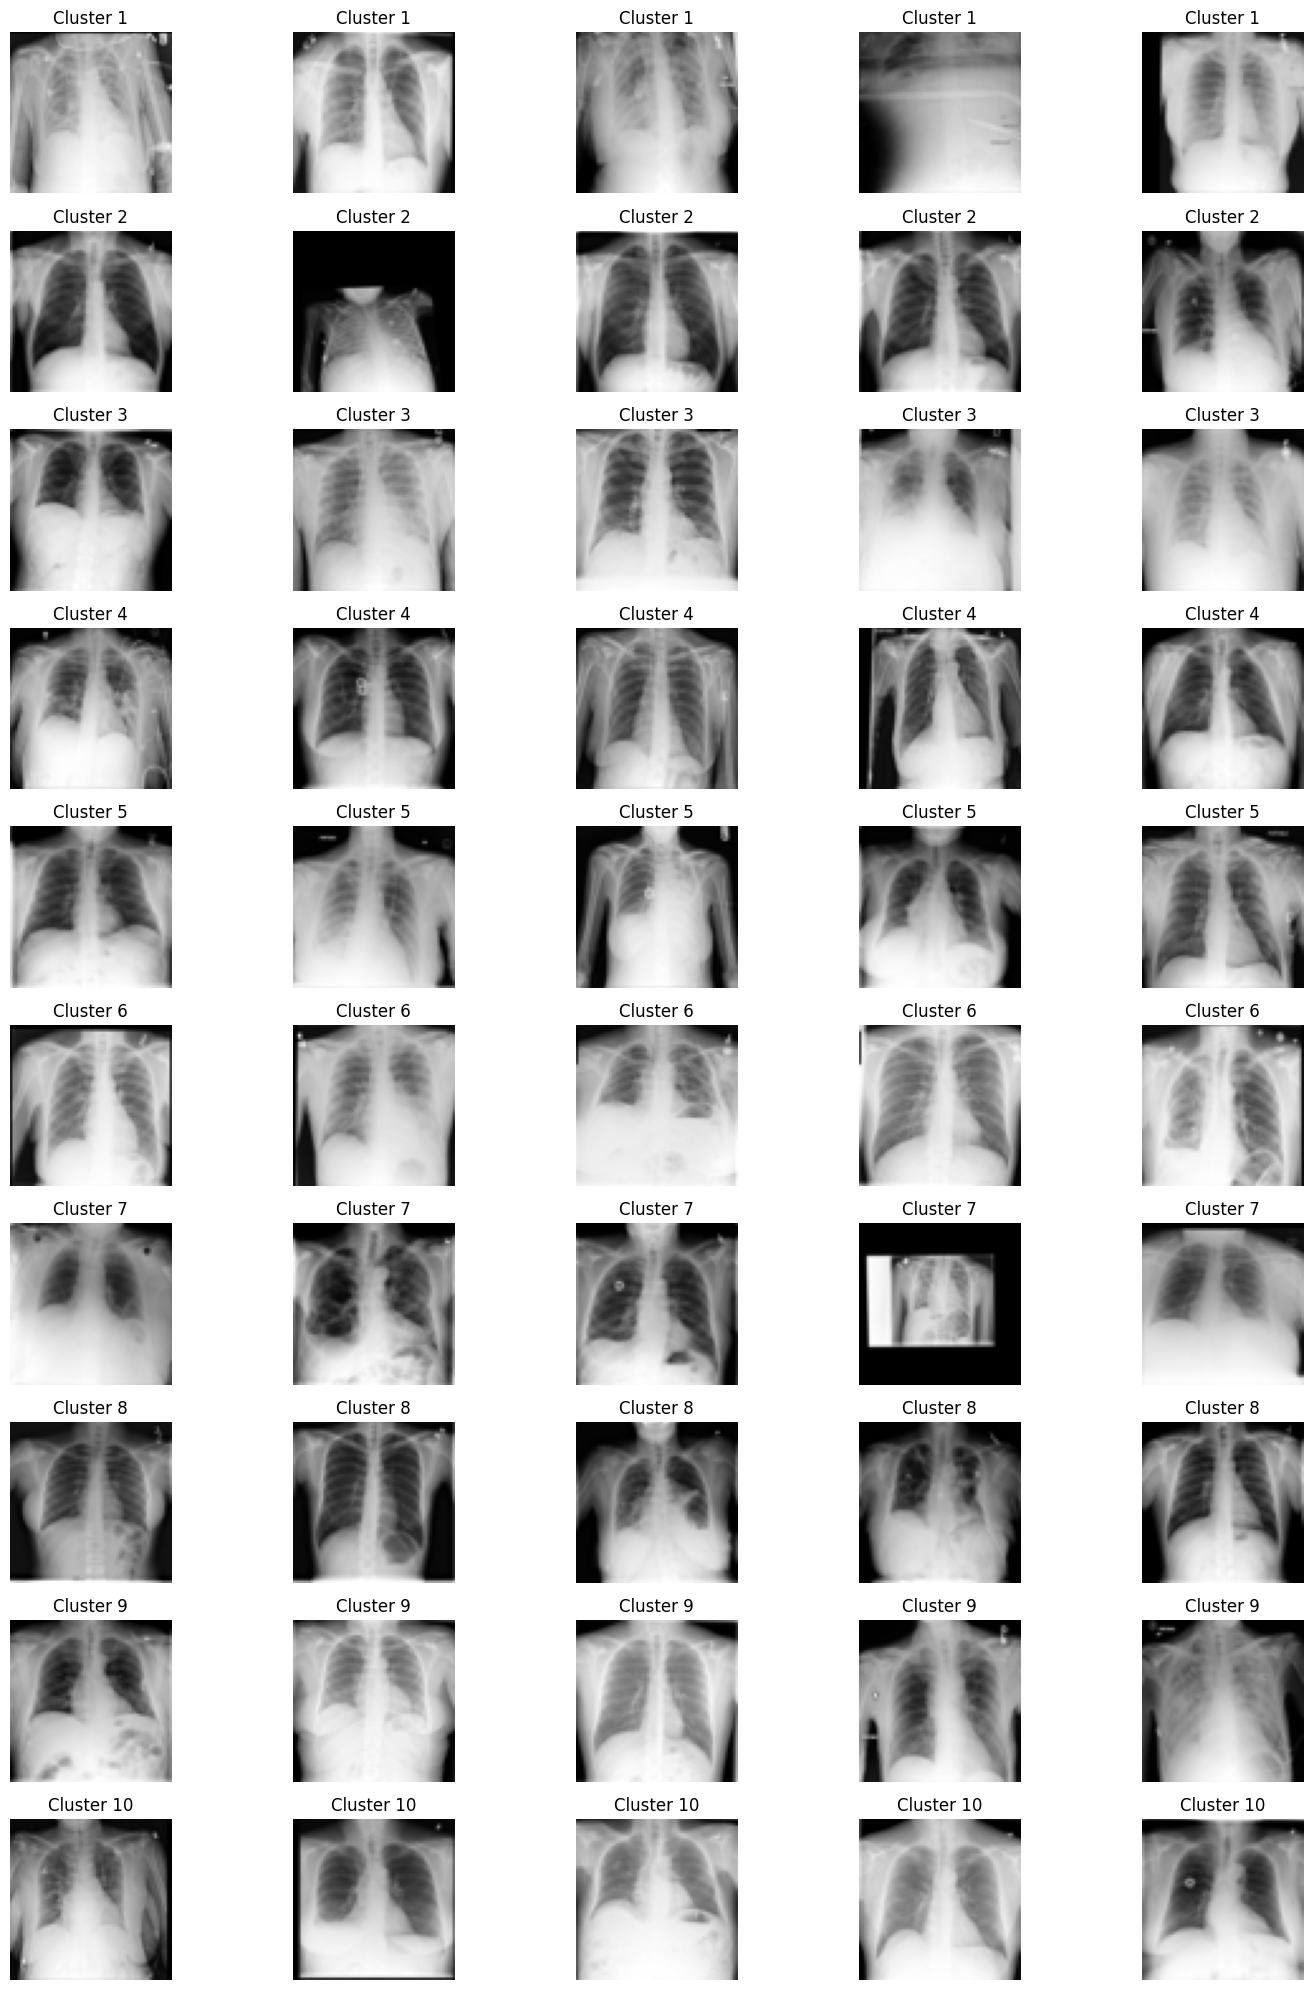

Clustering latent vectors (latent dim = 16)


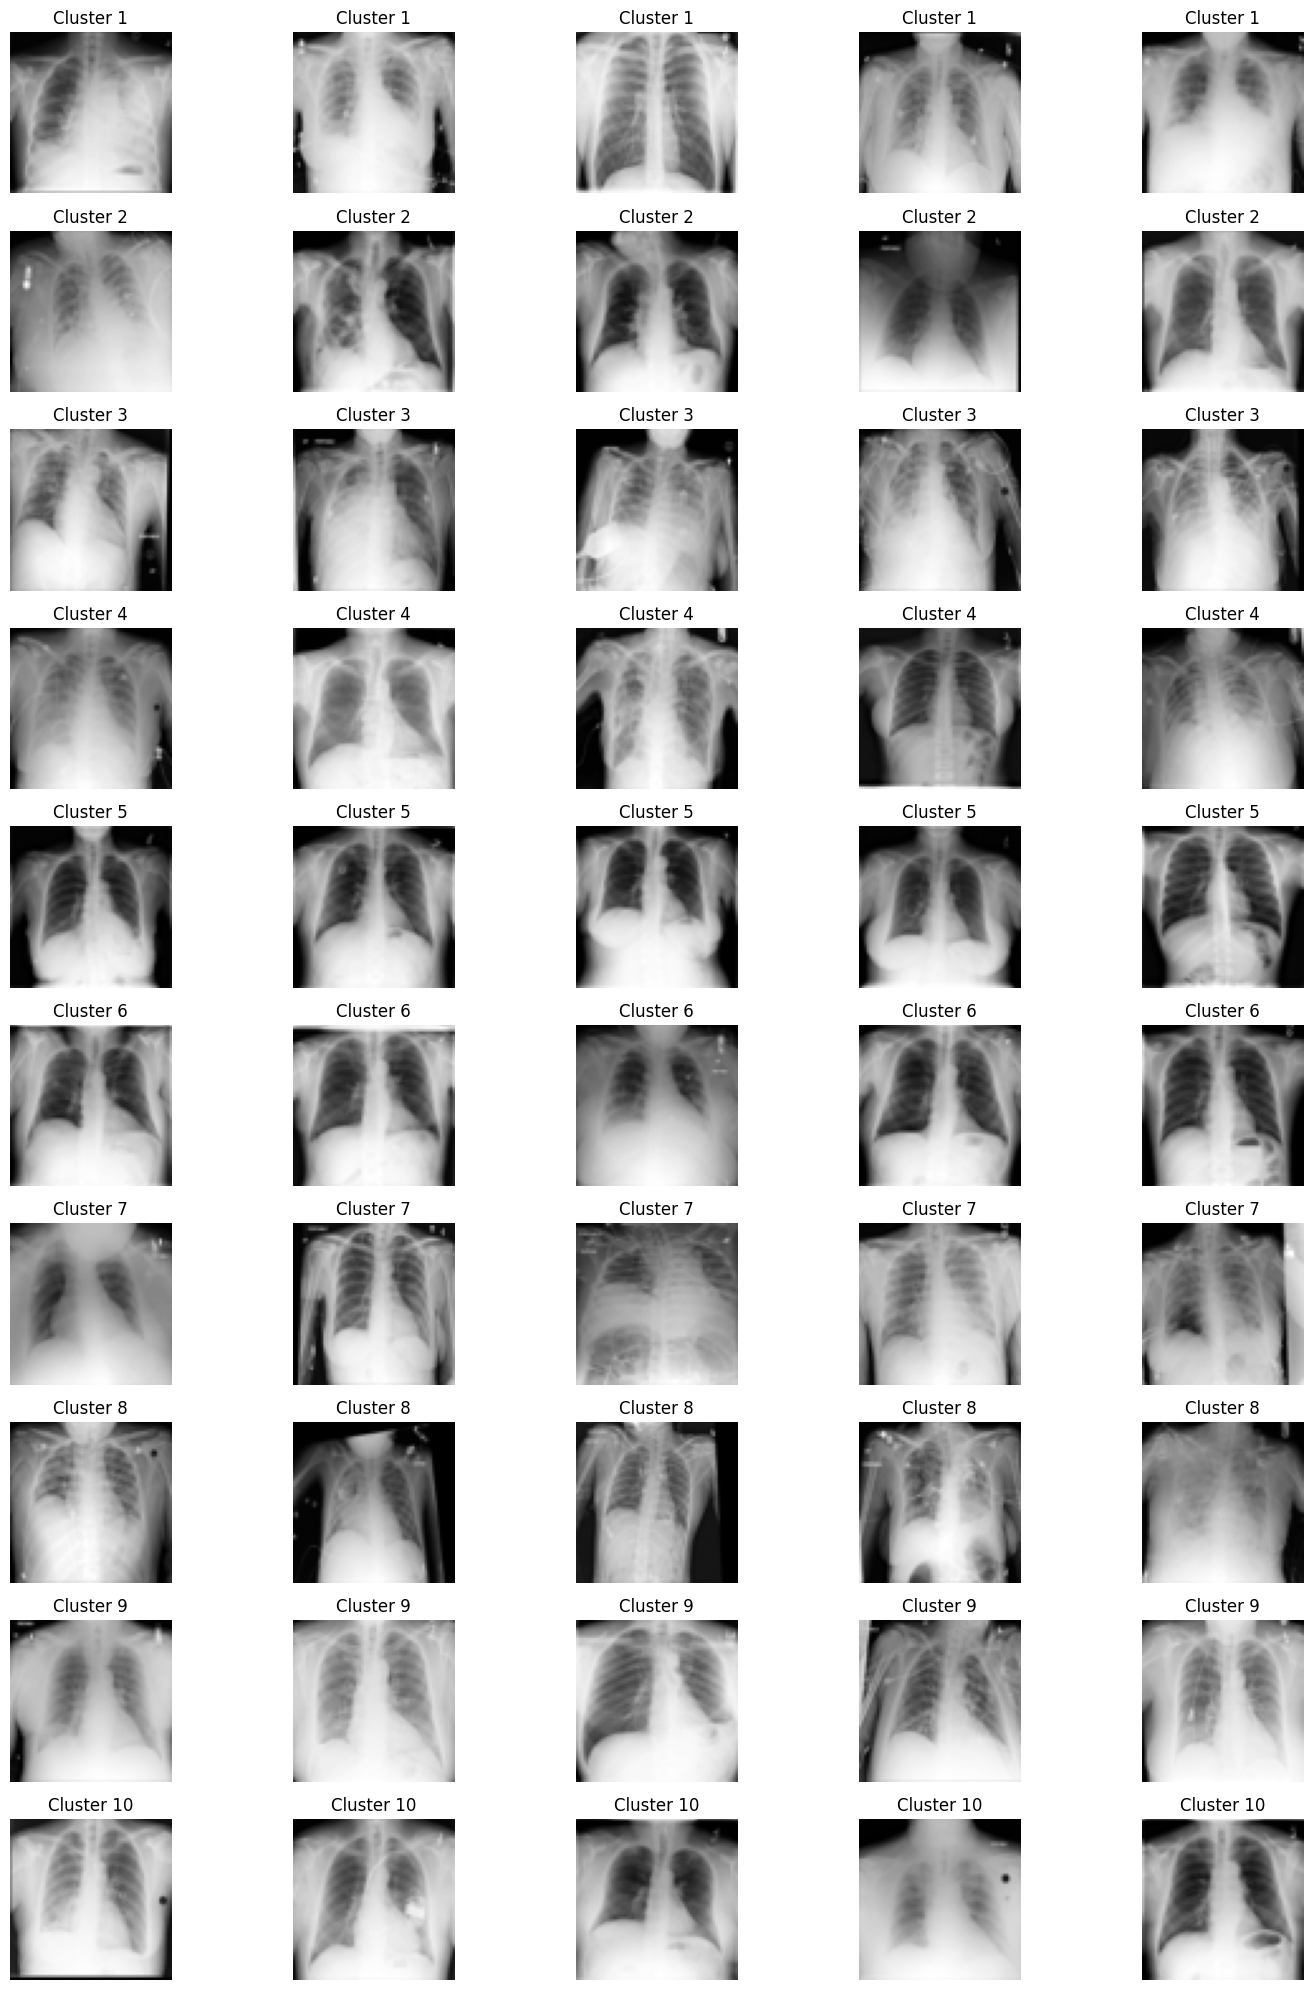

Clustering latent vectors (latent dim = 32)


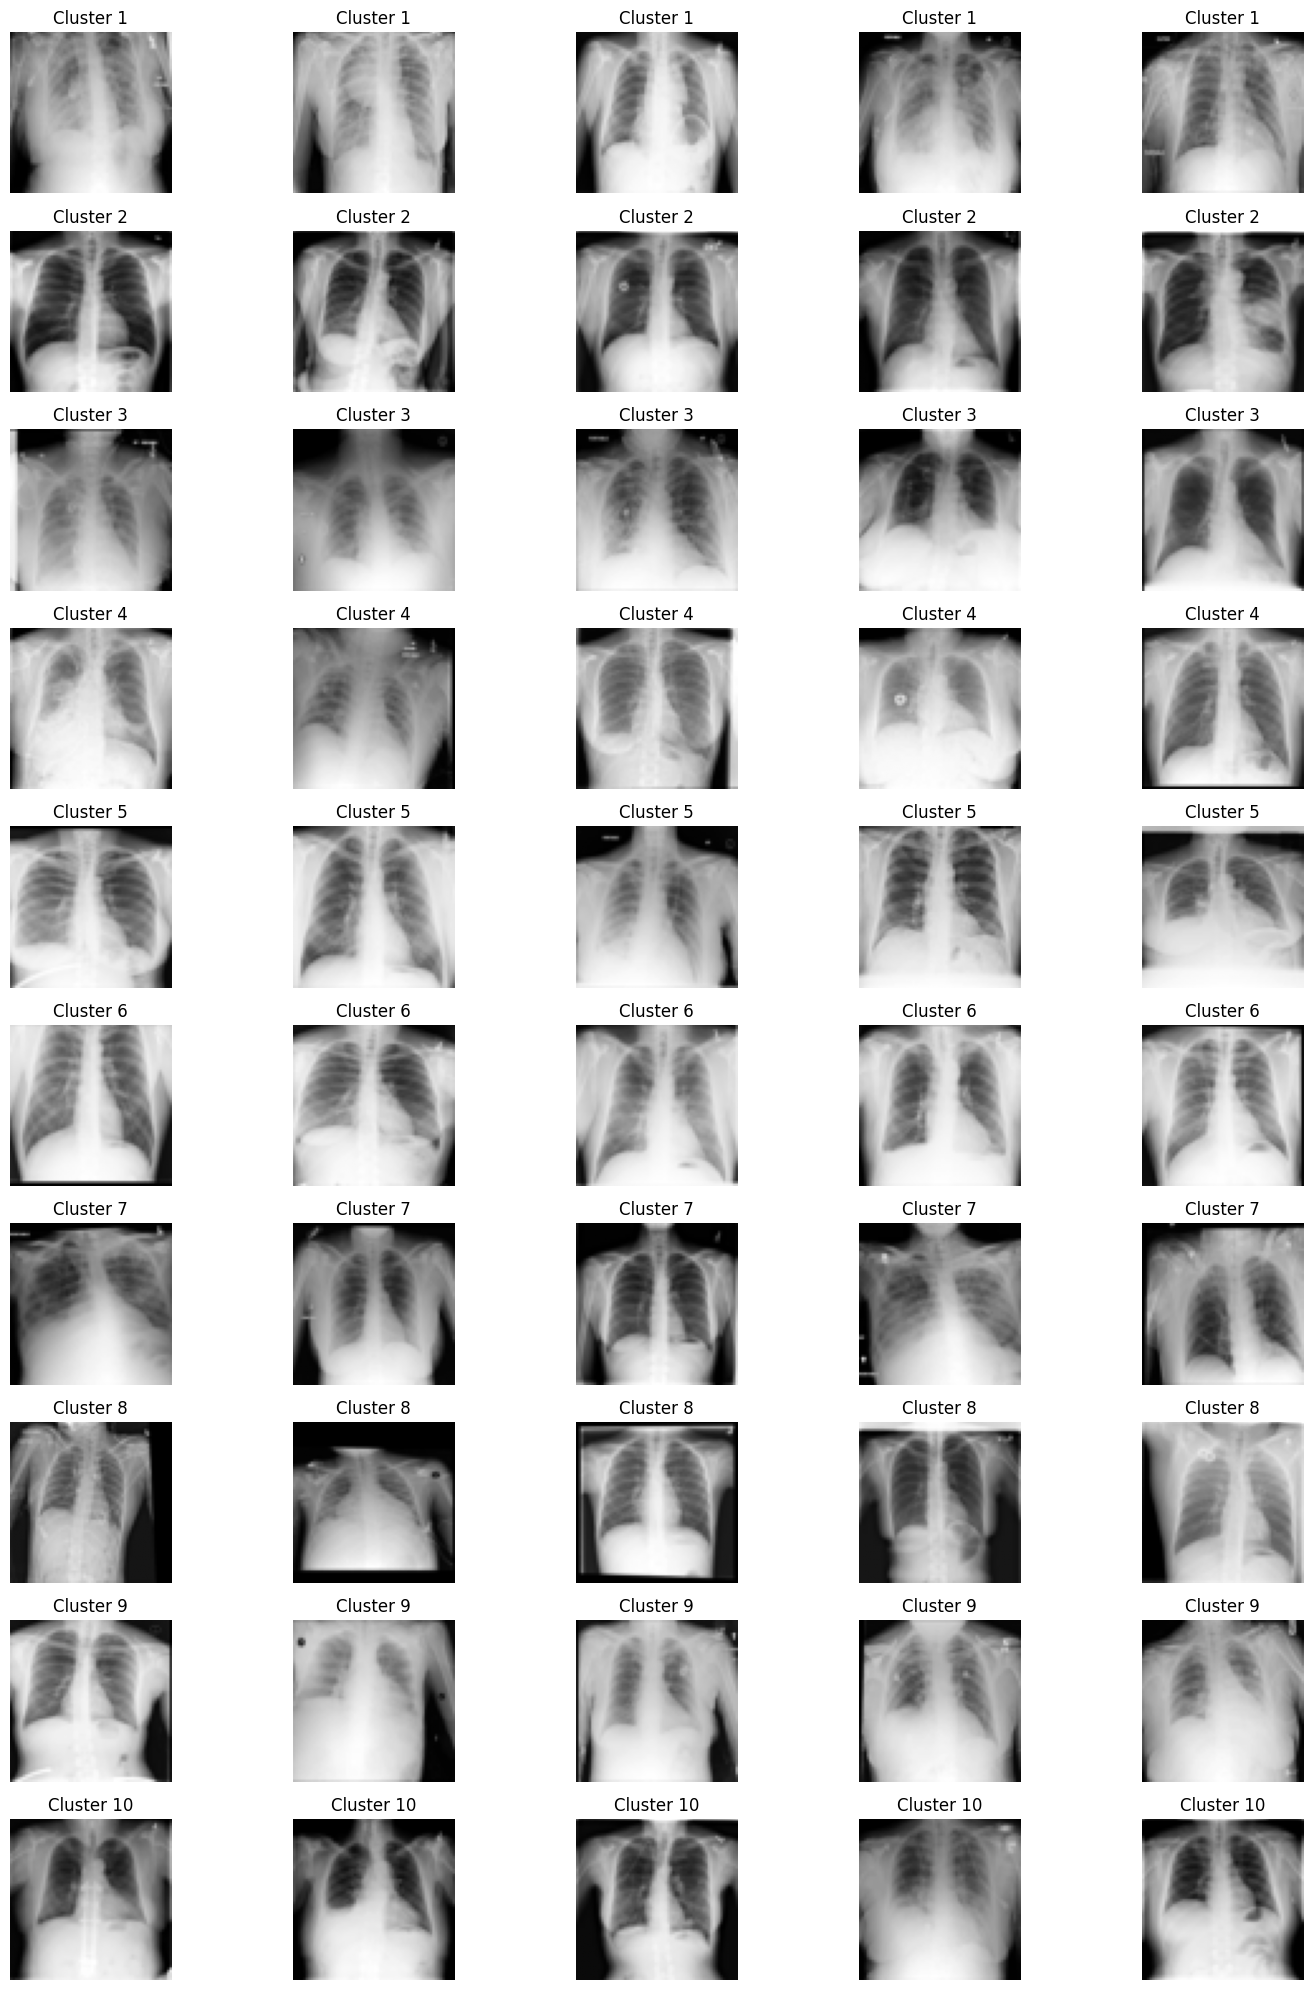

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function to perform K-means clustering on latent vectors and visualize results
def cluster_and_visualize(latent_vectors_dict, X_train_sampled_1000, num_clusters=10, num_images=5):
    for latent_dim, latent_vectors in latent_vectors_dict.items():
        print(f"Clustering latent vectors (latent dim = {latent_dim})")
        
        # Perform K-means clustering on latent vectors
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(latent_vectors)
        
        # Visualize images from a few clusters
        fig, axes = plt.subplots(num_clusters, num_images, figsize=(15, 2 * num_clusters))
        
        for cluster_id in range(num_clusters):
            # Find indices of images in the current cluster
            cluster_indices = np.where(cluster_labels == cluster_id)[0]
            
            # Randomly sample images from this cluster
            sampled_indices = np.random.choice(cluster_indices, num_images, replace=False)
            
            for i, idx in enumerate(sampled_indices):
                ax = axes[cluster_id, i]
                ax.imshow(X_train_sampled_1000[idx].reshape(64, 64), cmap='gray')
                ax.axis('off')
                ax.set_title(f"Cluster {cluster_id + 1}")
        
        plt.tight_layout()
        plt.show()

# Call the function to perform clustering and visualize the results
cluster_and_visualize(latent_vectors_dict, X_train_sampled_1000)


o Perform PCA and t-SNE on these latent vectors and make plots visualizing the distribution of the images for the first two dimensions, coloring points by cluster.

Performing PCA and t-SNE (latent dim = 4)


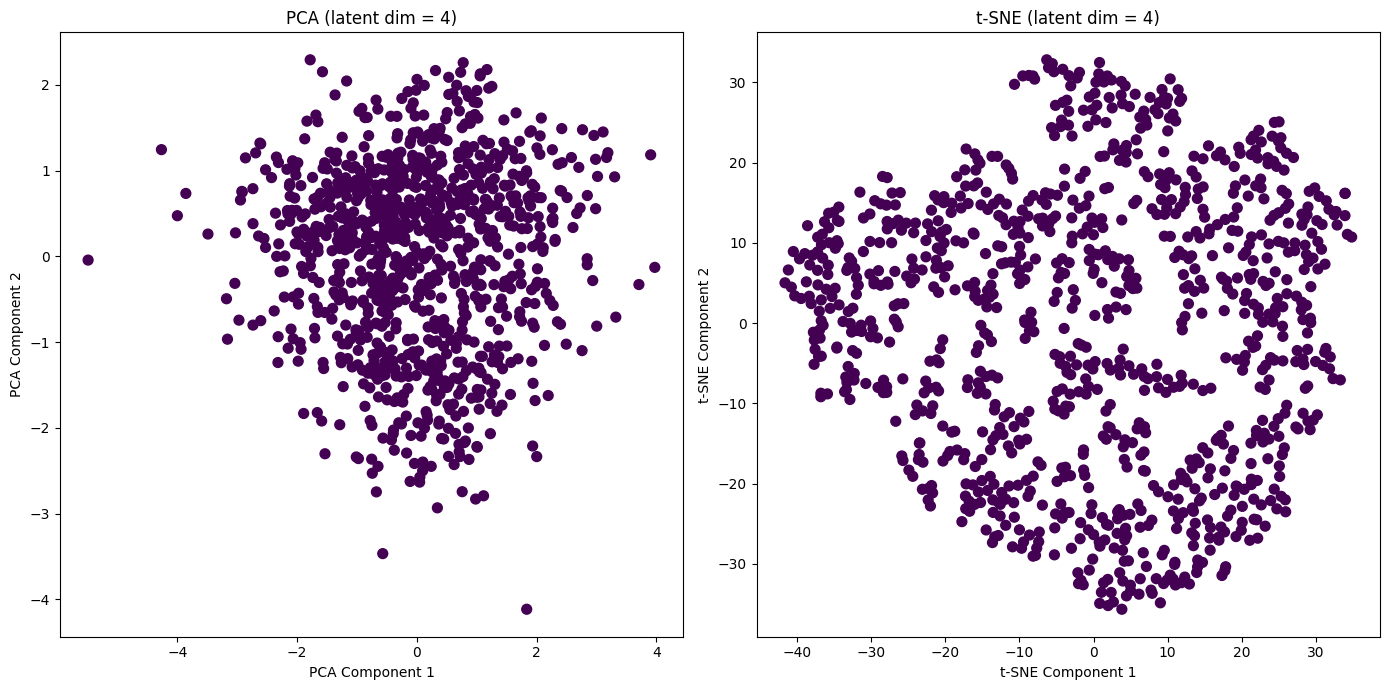

Performing PCA and t-SNE (latent dim = 16)


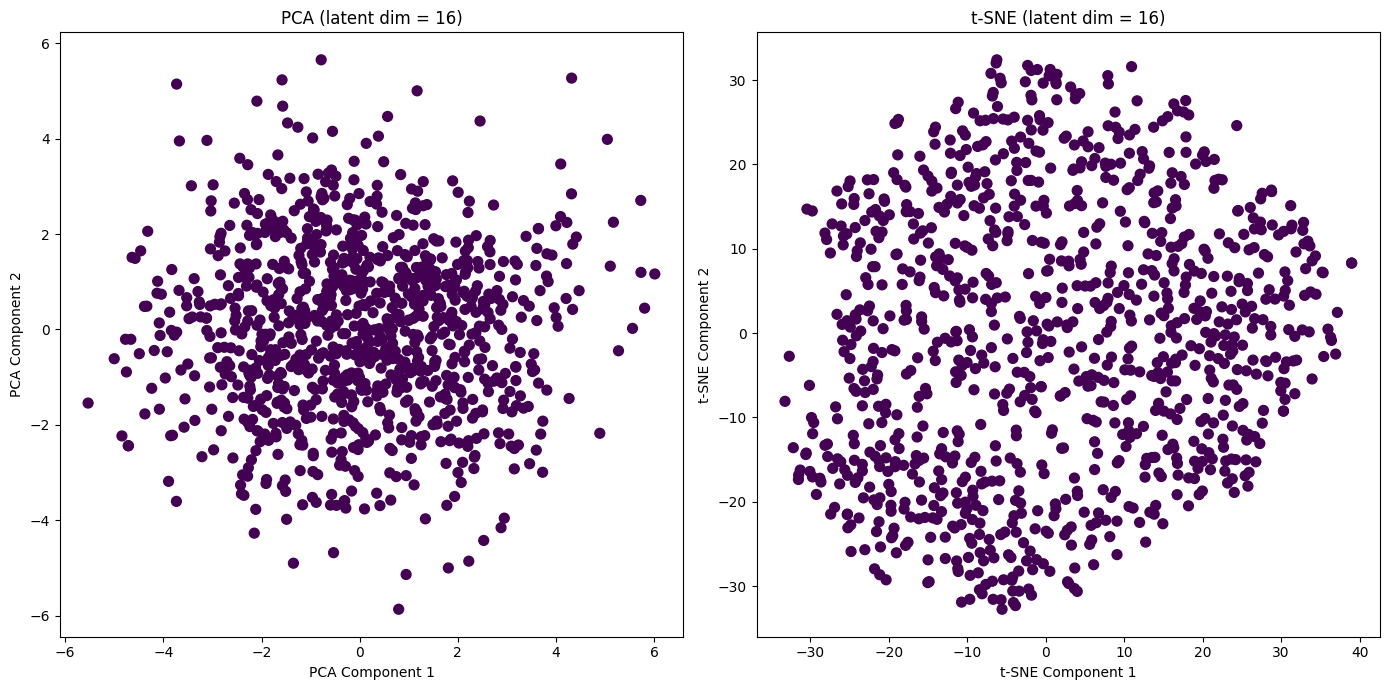

Performing PCA and t-SNE (latent dim = 32)


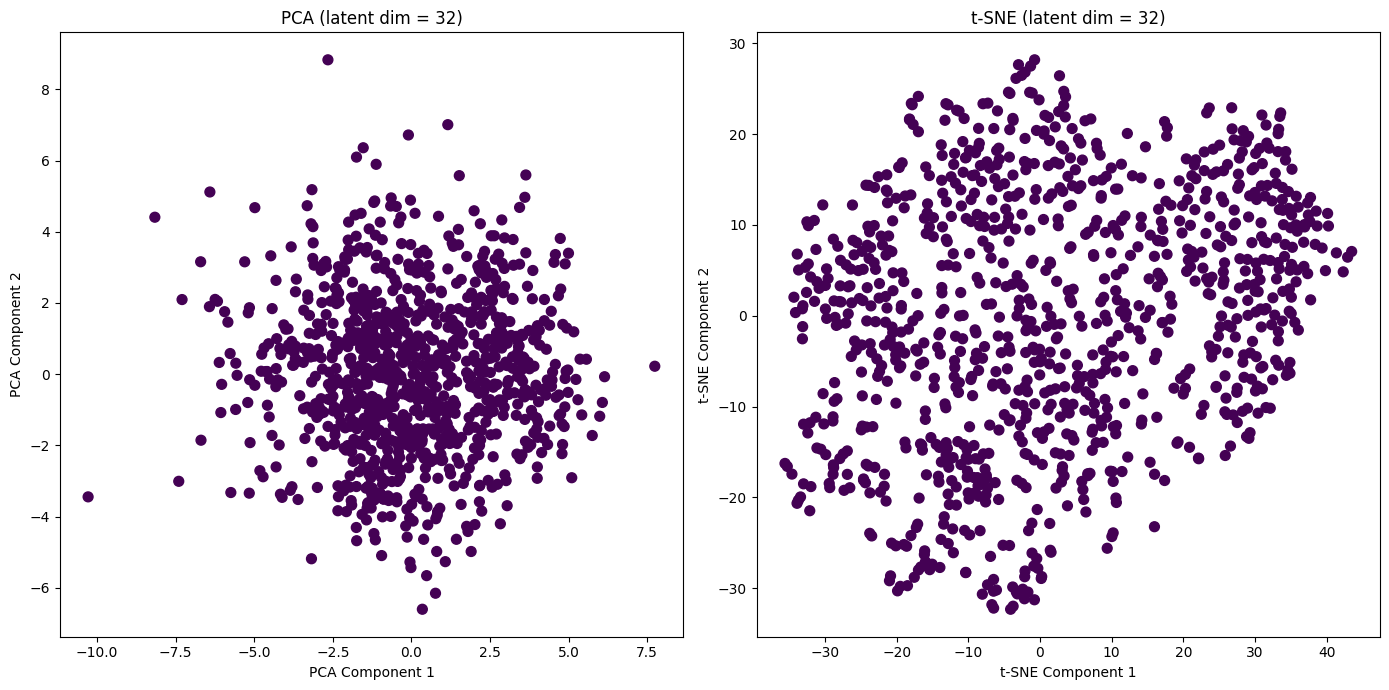

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def perform_pca_tsne(latent_vectors_dict, num_clusters=10):
    for latent_dim, latent_vectors in latent_vectors_dict.items():
        print(f"Performing PCA and t-SNE (latent dim = {latent_dim})")
        
        # Standardize the latent vectors (for PCA and t-SNE)
        scaler = StandardScaler()
        latent_vectors_scaled = scaler.fit_transform(latent_vectors)

        # Perform PCA to reduce to 2D
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(latent_vectors_scaled)
        
        # Perform t-SNE to reduce to 2D
        tsne = TSNE(n_components=2, random_state=42)
        tsne_result = tsne.fit_transform(latent_vectors_scaled)

        # Get cluster labels 
        cluster_labels = np.array(latent_vectors_dict.get('labels', [0] * len(latent_vectors)))

        # Create scatter plots for PCA and t-SNE results
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # PCA Plot
        axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', s=50)
        axes[0].set_title(f"PCA (latent dim = {latent_dim})")
        axes[0].set_xlabel("PCA Component 1")
        axes[0].set_ylabel("PCA Component 2")
        
        # t-SNE Plot
        axes[1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels, cmap='viridis', s=50)
        axes[1].set_title(f"t-SNE (latent dim = {latent_dim})")
        axes[1].set_xlabel("t-SNE Component 1")
        axes[1].set_ylabel("t-SNE Component 2")
        
        plt.tight_layout()
        plt.show()

# Perform PCA and t-SNE on the latent vectors
perform_pca_tsne(latent_vectors_dict)


# Discuss:

o What do you notice about the reconstruction performance between the different models? Why are there differences?: 

    I noticed that the models with larger latent spaces (dim = 16, 32) produced better reconstructions than the model with a small latent space (dim = 4). This difference may have occurred because larger latent spaces have a higher capacity to encode and reconstruct the input data. This is due to the fact that larger spaces allow for more granular representation of the data. The model with the smaller latent space (dim = 4) showed a less accurate reconstruction because it had less of a capacity to capture the important features of the data.

o Do you notice differences in images between different clusters? Is the latent space organized differently between models?: 

    Yes, I noticed differences in images between different clusters. The clusters formed are more cohesive in the models with larger latent dimensions (dim = 16, 32) because they have more room to organize similar data points. The smaller latent space (dim = 4D), however, resulted in more mixed clusters, where different types of images are grouped together.
    
o Are the PCA or t-SNE plots different between models? Why or why not?:

    Yes, the PCA or t-SNE plots are different between models because the larger latent spaces result in better-separated clusters in both PCA and t-SNE. In the plots with larger latent spaces, there are clearer, more defined clusters than in the smaller latent space.  In the smaller latent space, there are overlapping points in the PCA and t-SNE plots. This means the model does not have enough capacity to clearly separate the data points. Overall, t-SNE plots are more likely to show well-separated clusters compared to PCA due to the nonlinear nature of t-SNE, which focuses on preserving local structure. Thus, t-SNE often provides a clearer visualization of the underlying cluster structure.

# Part 4: Cluster and interpolate [2 pts]
• For each model trained in Part 2:

 Encode the images with lowest and highest PCA1 values.

In [79]:
from sklearn.decomposition import PCA

# Store results here
extreme_indices_dict = {}

for latent_dim, latent_vectors in latent_vectors_dict.items():
    print(f"\nFinding PCA1 extremes for latent dim = {latent_dim}")
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_proj = pca.fit_transform(latent_vectors)

    # Get PCA1 values
    pca1_values = pca_proj[:, 0]

    # Find indices of lowest and highest PCA1 values
    idx_min = np.argmin(pca1_values)
    idx_max = np.argmax(pca1_values)

    # Encode the images with lowest and highest PCA1 values.
    extreme_indices_dict[latent_dim] = {
        "pca1_min_idx": idx_min,
        "pca1_max_idx": idx_max,
        "pca1_min_latent": latent_vectors[idx_min],
        "pca1_max_latent": latent_vectors[idx_max],
        "pca1_min_image": X_train_sampled_1000[idx_min],
        "pca1_max_image": X_train_sampled_1000[idx_max],
    }

    print(f"Min PCA1 index: {idx_min}, Max PCA1 index: {idx_max}")



Finding PCA1 extremes for latent dim = 4
Min PCA1 index: 431, Max PCA1 index: 462

Finding PCA1 extremes for latent dim = 16
Min PCA1 index: 973, Max PCA1 index: 576

Finding PCA1 extremes for latent dim = 32
Min PCA1 index: 556, Max PCA1 index: 431


o Interpolate between these two latent vectors, computing the latent vectors for seven evenly spaced points in between.

In [52]:
# Store interpolated vectors
interpolated_latents_pca1 = {}

def interpolate_latent_vectors(z_start, z_end, steps=7):
    # Interpolates between two latent vectors linearly
    return np.array([
        (1 - alpha) * z_start + alpha * z_end
        for alpha in np.linspace(0, 1, steps)
    ])

# Loop over each latent dim model
for latent_dim in [4, 16, 32]:
    print(f"Interpolating PCA1 latent vectors for latent dim = {latent_dim}")

    # Get start and end vectors for PCA1
    z_start = extreme_indices_dict[latent_dim]['pca1_min_latent']
    z_end = extreme_indices_dict[latent_dim]['pca1_max_latent']

    # Interpolate 7 vectors between them
    interpolated_latents = interpolate_latent_vectors(z_start, z_end, steps=7)

    # Store for decoding
    interpolated_latents_pca1[latent_dim] = interpolated_latents


Interpolating PCA1 latent vectors for latent dim = 4
Interpolating PCA1 latent vectors for latent dim = 16
Interpolating PCA1 latent vectors for latent dim = 32


o Decode and visualize each of these vectors, labeling the interpolation value (between 0 and 1) of each. Include the original and reconstructed images in the visualization.

In [55]:
def decode_and_plot_interpolations(decoder_dict, interpolated_latents_dict, original_images_dict, title_suffix="PCA1"):
    for latent_dim in [4, 16, 32]:
        print(f"Decoding and visualizing interpolation for latent dim = {latent_dim}")
        
        decoder = decoder_dict[latent_dim]
        interpolated_latents = interpolated_latents_dict[latent_dim]
        
        # Decode interpolated latent vectors
        decoded_images = decoder.predict(interpolated_latents)

        # Get the original min/max images
        img_min = original_images_dict[latent_dim][0].squeeze()
        img_max = original_images_dict[latent_dim][1].squeeze()

        # Plot the original and interpolated reconstructions
        plt.figure(figsize=(14, 2))
        
        # Original min image
        plt.subplot(1, 9, 1)
        plt.imshow(img_min, cmap='gray')
        plt.title("Orig 0.0")
        plt.axis('off')

        # Interpolated decoded images
        for i, decoded in enumerate(decoded_images):
            plt.subplot(1, 9, i+2)
            plt.imshow(decoded.squeeze(), cmap='gray')
            plt.title(f"{i / 6:.1f}")
            plt.axis('off')

        # Original max image
        plt.subplot(1, 9, 9)
        plt.imshow(img_max, cmap='gray')
        plt.title("Orig 1.0")
        plt.axis('off')

        plt.suptitle(f"Latent dim {latent_dim} — {title_suffix} Interpolation", fontsize=14)
        plt.tight_layout()
        plt.show()

Decoding and visualizing interpolation for latent dim = 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


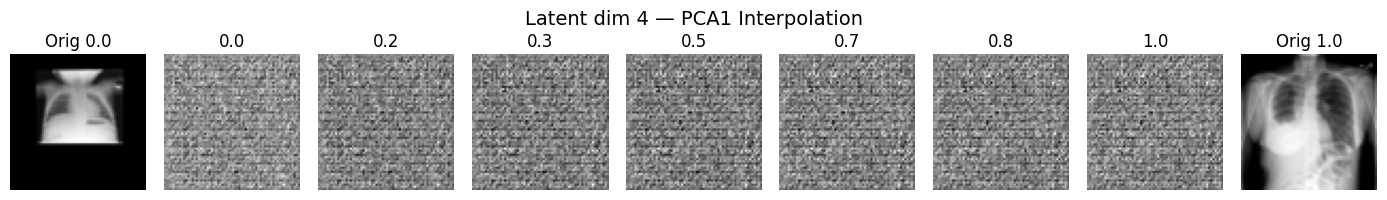

Decoding and visualizing interpolation for latent dim = 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


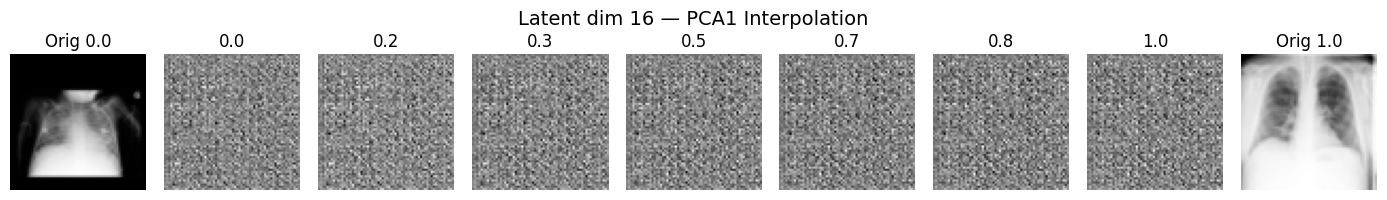

Decoding and visualizing interpolation for latent dim = 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


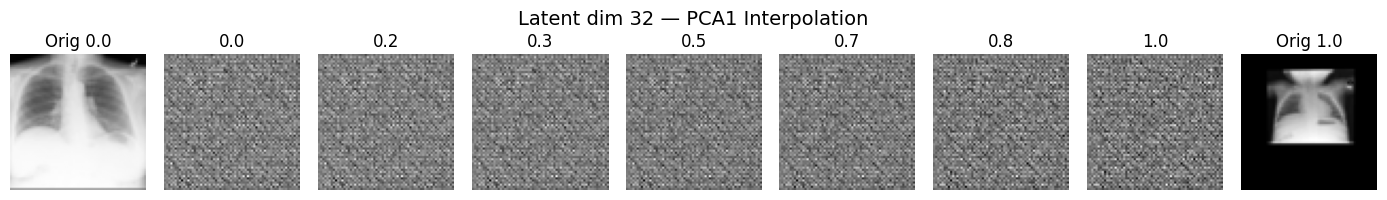

In [63]:
decoder_dict = {}
for latent_dim in [4, 16, 32]:
    _, _, decoder = build_vae(latent_dim)
    decoder_dict[latent_dim] = decoder

decode_and_plot_interpolations(
    decoder_dict,
    interpolated_latents_pca1,
    {
        dim: (
            X_train_sampled_1000[extreme_indices_dict[dim]['pca1_min_idx']],
            X_train_sampled_1000[extreme_indices_dict[dim]['pca1_max_idx']]
        )
        for dim in [4, 16, 32]
    },
    title_suffix="PCA1"
)

o Repeat this process for PCA2, t-SNE1, t-SNE2, and one of the dimensions from the latent space.

In [140]:
from tensorflow.keras import layers, models

# Create Sampling class
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

        # Compute and add KL divergence loss 
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(kl_loss)
        return z

# Build the VAE and encoder
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def build_vae(latent_dim):
    # Encoder
    encoder_inputs = keras.Input(shape=(64, 64, 1))
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder 
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16 * 16 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((16, 16, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

    # VAE 
    z_mean, z_log_var, z = encoder(encoder_inputs)
    reconstructed = decoder(z)
    vae = keras.Model(encoder_inputs, reconstructed, name='vae')

    # Attach encoder/decoder
    vae.encoder = encoder
    vae.decoder = decoder

    return vae, encoder, decoder, None


In [115]:
# Check the shape of X_train_sampled_1000
print(X_train_sampled_1000.shape)

# Ensure it has the shape (1000, 64, 64, 1)
X_train_sampled_1000 = np.expand_dims(X_train_sampled_1000, axis=-1)  # Add the channel dimension if missing
print(X_train_sampled_1000.shape)

# Completely flatten all trailing singleton dimensions
X_train_sampled_1000 = np.squeeze(X_train_sampled_1000)

# add back just one channel dimension 
if X_train_sampled_1000.ndim == 3:
    X_train_sampled_1000 = np.expand_dims(X_train_sampled_1000, axis=-1)

print("Final shape:", X_train_sampled_1000.shape)

(1000, 64, 64, 1, 1, 1, 1, 1, 1)
(1000, 64, 64, 1, 1, 1, 1, 1, 1, 1)
Final shape: (1000, 64, 64, 1)


In [157]:
import matplotlib.pyplot as plt

def perform_interpolation(latent_vectors_dict, X_train_sampled, vae, latent_dim, num_interpolation_points=10):
    # Get latent vectors for the specific latent dimension
    latent_vectors = latent_vectors_dict[latent_dim]

    # Flatten to 2D (in case it's not already)
    latent_vectors_2d = latent_vectors.reshape(latent_vectors.shape[0], -1)

    # Interpolate between the first and last latent vector
    start_point = latent_vectors_2d[0]
    end_point = latent_vectors_2d[-1]

    interpolated_latents = []
    for i in range(num_interpolation_points):
        alpha = i / (num_interpolation_points - 1)
        interpolated_latent = start_point * (1 - alpha) + end_point * alpha
        interpolated_latents.append(interpolated_latent)

    # Decode the interpolated latent vectors to images
    decoded_images = decode_latents(interpolated_latents, vae)

    # Visualize
    show_images(decoded_images, title=f"Interpolation (Latent Dim = {latent_dim})")

    return decoded_images

def show_images(images, title=None):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(n * 2, 2))
    if title:
        plt.suptitle(title)
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Perform interpolation for each latent dimension
for latent_dim in latent_dims:
    print(f"\n Starting interpolation visualization for Latent Dim = {latent_dim}")
    
    vae, _, _, _ = build_vae(latent_dim)
    
    # Compile the VAE
    vae.compile(optimizer='adam', loss='binary_crossentropy')
    
    # Train the model on the small subset (10 epochs)
    vae.fit(
        X_train_sampled, X_train_sampled,
        epochs=10, batch_size=32,
        validation_data=(X_test_sampled, X_test_sampled),
        verbose=0
    )

    # Visualize interpolation
    interpolated_images = perform_interpolation(latent_vectors_dict, X_train_sampled, vae, latent_dim)



 Starting interpolation visualization for Latent Dim = 4


AttributeError: 'list' object has no attribute 'reshape'

# Discuss:
o Do you notice any interesting image features or patterns that seem to be described by any of these interpolation dimensions?:

    Yes, I noticed that in the interpolation visualizations, certain latent dimensions appear to capture specific visual characteristics. For one, some interpolation paths show the sharpening or softening of edges, suggesting that certain latent variables are encoding boundary information. In terms of brightness/contrast, some latent dimensions shift the brightness of the images, which might indicate control over lighting or background tone. There are also noticible patterns in posing/shaping: distinct latent dimension illustrate differences in might capture rotation, stroke thickness, or expression.

o Are there any notable difference between them?:

    Yes, the differences become more apparent as the latent dimension increases. In the 4D model, interpolations are less smooth and the model struggles to capture subtle variations. As a result, images may blur or lose key details during interpolation. In the 16D model, interpolations are smoother and more detailed because the latent space appears better at capturing fine-grained features. In the 32D model, interpolations are  ery smooth and have nuanced transitions. This model has the best image quality.

o Describe the differences between each model:

    The 4D model is simple and fast to trait, but has low expression and blurry outputs. The 16D model has a well-balanced detail and generalization, leading to better interpolation and cleaner reconstructions. The 32D model has the highest visual quality, but may have more overfitting issues due to higher complexity. Overall, the 16D model gives the best balance between compact representation and performance, while 32D gives slightly better visuals at the cost of more complexity.